## Airbnb Scraper
Author: Dan Segal ([@djsegal](https://github.com/djsegal))

#### Import needed functionality 

In [104]:
import requests
import datetime
import gzip
import os

import pandas as pd

from bs4 import BeautifulSoup
from tqdm.auto import tqdm

import clean_data

from importlib import reload
reload(clean_data)

import time
import re

import numpy as np

import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import cpi
cpi.update()


#### Download zipped folders

In [2]:
soup = BeautifulSoup(open("data/airbnb/airbnb.html"), "html.parser")

rentals_table = soup.find("table", {"id": "js-detailed-table"})
rental_rows = rentals_table.find("tbody").find_all("tr")

for row in tqdm(rental_rows):
    cols = row.find_all("td")
    row_date, row_link = cols[0].text, cols[1].find("a")["href"]

    work_date = datetime.datetime.strptime(row_date, '%d %B, %Y')
    date_string = work_date.strftime("%Y_%m_%d")
    
    file_name, file_type = row_link.split("/")[-1].split(".",1)
    cur_file = f"{file_name}_{date_string}.{file_type}"
     
    abs_file_path = f'data/airbnb/zipped_data/{cur_file}'
    if os.path.exists(abs_file_path): continue
        
    cur_request = requests.get(row_link, allow_redirects=True)
    open(abs_file_path, 'wb').write(cur_request.content)
    

#### Prune rental files

In [3]:
for filename in tqdm(sorted(os.listdir("data/airbnb/zipped_data"))):
    if not filename.endswith(".csv.gz"): continue 
    
    cur_file = f'data/airbnb/zipped_data/{filename}'
    with gzip.open(cur_file, 'rb') as f:
        file_data = pd.read_csv(cur_file, low_memory=False);
        file_data = clean_data.clean_airbnb_data(file_data)
        
        work_date = datetime.datetime.strptime(
            re.search("\d{4}_\d{2}_\d{2}", filename)[0], '%Y_%m_%d'
        ).replace(day=1)
        
        if work_date.month == 1:
            work_date = work_date.replace(month=12, year=work_date.year-1)
        else:
            work_date = work_date.replace(month=work_date.month-1)
          
        file_data["date"] = work_date
        file_data["month"] = work_date.month
        file_data["year"] = work_date.year

        csv_file = f'data/airbnb/csv_data/{filename.replace(".gz", "")}'
        file_data.to_csv(csv_file, index=False)
        

#### Compile airbnb database

In [151]:
airbnb_data = None

for filename in tqdm(sorted(os.listdir("data/airbnb/csv_data"))):
    if not filename.endswith(".csv"): continue 
    
    cur_file = f'data/airbnb/csv_data/{filename}'
    work_data = pd.read_csv(cur_file, low_memory=False)
    
    if airbnb_data is None:
        airbnb_data = work_data
    else:
        airbnb_data = airbnb_data.append(work_data)

airbnb_data.sort_values(["neighbourhood_group", "id", "date"], ascending=False, inplace=True)

backup_data_1 = airbnb_data.copy()


#### Test database uniformity

In [152]:
test_columns = [
    'id', 'neighbourhood', 'neighbourhood_group',
    'latitude', 'longitude', 'property_type',
    'accommodates', 'bathrooms', 'bedrooms',
    'beds', 'price', 'number_of_reviews',
    'review_scores_rating', 'date', 'month', 'year'
]

assert list(airbnb_data.columns) == test_columns

airbnb_data

,id,neighbourhood,neighbourhood_group,latitude,longitude,property_type,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,review_scores_rating,date,month,year
3783,37493902,Murray Hill,Manhattan,40.747840,-73.977990,Apartment,6,1.0,2.0,3.0,350.0,0,NaN,2019-07-01,7,2019
3779,37461821,Upper West Side,Manhattan,40.797230,-73.961320,Apartment,6,1.0,2.0,3.0,350.0,0,NaN,2019-07-01,7,2019
3778,37461048,Upper West Side,Manhattan,40.790210,-73.969380,Apartment,4,1.0,1.0,2.0,250.0,0,NaN,2019-07-01,7,2019
3774,37448242,Upper East Side,Manhattan,40.776360,-73.953020,Apartment,5,1.0,1.0,1.0,249.0,0,NaN,2019-07-01,7,2019
3773,37447887,Lower East Side,Manhattan,40.720660,-73.983850,Apartment,4,1.0,2.0,2.0,312.0,1,100.0,2019-07-01,7,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5500,3831,Clinton Hill,Brooklyn,40.685138,-73.959757,Townhouse,3,1.0,1.0,3.0,89.0,69,91.0,2016-07-01,7,2016
1276,3831,Clinton Hill,Brooklyn,40.685138,-73.959757,Townhouse,3,1.0,1.0,3.0,89.0,66,91.0,2016-06-01,6,2016
1266,3831,Clinton Hill,Brooklyn,40.685138,-73.959757,Townhouse,3,1.0,1.0,3.0,85.0,61,91.0,2016-05-01,5,2016
1179,3831,Clinton Hill,Brooklyn,40.685138,-73.959757,Townhouse,3,1.0,1.0,3.0,85.0,57,92.0,2016-04-01,4,2016


#### Remove bad data

In [153]:
airbnb_data = backup_data_1.copy()


In [154]:
unique_ids = sorted(airbnb_data.id.unique())

novice_ids = []
unreviewed_ids = []
bad_ids = []
moved_ids = []    
slow_ids = []
geo_ids = []

for unique_id in tqdm(unique_ids):
    sub_data = airbnb_data[airbnb_data.id == unique_id]
    
    if len(sub_data) < 3: novice_ids.append(unique_id)
    if len(sub_data.neighbourhood_group.unique()) > 1: moved_ids.append(unique_id)
        
    if sub_data.review_scores_rating.iloc[0] < 50: bad_ids.append(unique_id)
    if sub_data.number_of_reviews.max() < 5: unreviewed_ids.append(unique_id)
        
    max_reviews = sub_data.number_of_reviews.max()
    min_reviews = sub_data.number_of_reviews.min()

    cur_rate = ( max_reviews - min_reviews ) / len(sub_data)
    if cur_rate < 0.16: slow_ids.append(unique_ids)
   
    lat_err = (1-sub_data["latitude"]/sub_data["latitude"].mean()).abs().max()
    if lat_err > 1e-5: 
        geo_ids.append(unique_id)
        continue
        
    lon_err = (1-sub_data["longitude"]/sub_data["longitude"].mean()).abs().max()
    if lon_err > 5e-5: 
        geo_ids.append(unique_id)
        continue

old_count = len(airbnb_data)
airbnb_data = airbnb_data[~airbnb_data.id.isin(novice_ids)]
airbnb_data = airbnb_data[~airbnb_data.id.isin(unreviewed_ids)]
airbnb_data = airbnb_data[~airbnb_data.id.isin(bad_ids)]
airbnb_data = airbnb_data[~airbnb_data.id.isin(moved_ids)]
airbnb_data = airbnb_data[~airbnb_data.id.isin(slow_ids)]
airbnb_data = airbnb_data[~airbnb_data.id.isin(geo_ids)]
new_count = len(airbnb_data)

time.sleep(0.5)

print(f"beg: {old_count}")
print(f"novice: {len(novice_ids)}")
print(f"unreviewed: {len(unreviewed_ids)}")
print(f"bad: {len(bad_ids)}")
print(f"moved: {len(moved_ids)}")
print(f"slow: {len(slow_ids)}")
print(f"geo: {len(geo_ids)}")
print(f"end: {new_count}")



beg: 201303
novice: 7287
unreviewed: 8280
bad: 87
moved: 3
slow: 7952
geo: 3699
end: 100786


#### Clean up data

In [155]:
airbnb_data["month_count"] = np.nan

unique_ids = sorted(airbnb_data.id.unique())

for unique_id in tqdm(unique_ids):
    sub_data = airbnb_data[airbnb_data.id == unique_id]

    cur_count = len(sub_data)
   
    cur_type = sub_data.property_type.iloc[0]
    cur_neighbourhood = sub_data.neighbourhood.iloc[0]
 
    cur_review_count = sub_data.number_of_reviews.iloc[0]
    cur_review_score = sub_data.review_scores_rating.iloc[0]
    
    cur_latitude = np.mean(sub_data.latitude.mode())
    cur_longitude = np.mean(sub_data.longitude.mode())
    
    assert len(sub_data.latitude.unique()) <= len(sub_data.latitude)
    assert len(sub_data.longitude.unique()) <= len(sub_data.longitude)
    
    cur_rental_dict = {
        "property_type": cur_type,
        "latitude": cur_latitude,
        "longitude": cur_longitude,
        "month_count": cur_count,
        "neighbourhood": cur_neighbourhood,
        "number_of_reviews": cur_review_count,
        "review_scores_rating": cur_review_score
    }
    
    for cur_key, cur_value in cur_rental_dict.items():
        airbnb_data.loc[airbnb_data.id == unique_id, cur_key] = cur_value
   
airbnb_data.dropna(subset=["review_scores_rating"], inplace=True)

airbnb_data.sort_values(["neighbourhood_group", "month_count", "id", "date"], ascending=False, inplace=True)

backup_data_2 = airbnb_data.copy()

airbnb_data

,id,neighbourhood,neighbourhood_group,latitude,longitude,property_type,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,review_scores_rating,date,month,year,month_count
1211,9955143,Lower East Side,Manhattan,40.712823,-73.989152,Apartment,2,1.0,1.0,1.0,145.0,70,92.0,2019-07-01,7,2019,41.0
1246,9955143,Lower East Side,Manhattan,40.712823,-73.989152,Apartment,2,1.0,1.0,1.0,145.0,70,92.0,2019-06-01,6,2019,41.0
1314,9955143,Lower East Side,Manhattan,40.712823,-73.989152,Apartment,2,1.0,1.0,1.0,145.0,70,92.0,2019-05-01,5,2019,41.0
1616,9955143,Lower East Side,Manhattan,40.712823,-73.989152,Apartment,2,1.0,1.0,1.0,145.0,70,92.0,2019-04-01,4,2019,41.0
2774,9955143,Lower East Side,Manhattan,40.712823,-73.989152,Apartment,2,1.0,1.0,1.0,145.0,70,92.0,2019-03-01,3,2019,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,40012,Park Slope,Brooklyn,40.675246,-73.972903,Apartment,2,1.0,1.0,1.0,200.0,16,97.0,2016-04-01,4,2016,3.0
3858,40012,Park Slope,Brooklyn,40.675246,-73.972903,Apartment,2,1.0,1.0,1.0,200.0,16,97.0,2016-03-01,3,2016,3.0
5116,7121,Prospect Heights,Brooklyn,40.680167,-73.965393,Apartment,2,1.0,1.0,1.0,375.0,5,100.0,2016-09-01,9,2016,3.0
3383,7121,Prospect Heights,Brooklyn,40.680167,-73.965393,Apartment,2,1.0,1.0,1.0,375.0,5,100.0,2016-08-01,8,2016,3.0


### Add new columns

In [156]:
airbnb_data = backup_data_2.copy()


In [165]:
def convert_money(cpi_price, cpi_date):
    cpi_date = datetime.datetime.strptime(cpi_date, '%Y-%m-%d')
    
    return cpi.inflate(
        cpi_price, cpi_date, 
        to=datetime.datetime(year=cpi_date.year, month=1, day=1), 
        area="New York-Newark-Jersey City, NY-NJ-PA", items="Housing"
    )

airbnb_data["adjusted_price"] = [ 
    convert_money(cpi_price, cpi_date) for cpi_price, cpi_date in zip(airbnb_data.price, airbnb_data.date) 
]


In [166]:
airbnb_data

,id,neighbourhood,neighbourhood_group,latitude,longitude,property_type,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,review_scores_rating,date,month,year,month_count,adjusted_price
1211,9955143,Lower East Side,Manhattan,40.712823,-73.989152,Apartment,2,1.0,1.0,1.0,145.0,70,92.0,2019-07-01,7,2019,41.0,143.686902
1246,9955143,Lower East Side,Manhattan,40.712823,-73.989152,Apartment,2,1.0,1.0,1.0,145.0,70,92.0,2019-06-01,6,2019,41.0,143.821309
1314,9955143,Lower East Side,Manhattan,40.712823,-73.989152,Apartment,2,1.0,1.0,1.0,145.0,70,92.0,2019-05-01,5,2019,41.0,144.495222
1616,9955143,Lower East Side,Manhattan,40.712823,-73.989152,Apartment,2,1.0,1.0,1.0,145.0,70,92.0,2019-04-01,4,2019,41.0,144.389626
2774,9955143,Lower East Side,Manhattan,40.712823,-73.989152,Apartment,2,1.0,1.0,1.0,145.0,70,92.0,2019-03-01,3,2019,41.0,144.687217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,40012,Park Slope,Brooklyn,40.675246,-73.972903,Apartment,2,1.0,1.0,1.0,200.0,16,97.0,2016-04-01,4,2016,3.0,198.383936
3858,40012,Park Slope,Brooklyn,40.675246,-73.972903,Apartment,2,1.0,1.0,1.0,200.0,16,97.0,2016-03-01,3,2016,3.0,198.622849
5116,7121,Prospect Heights,Brooklyn,40.680167,-73.965393,Apartment,2,1.0,1.0,1.0,375.0,5,100.0,2016-09-01,9,2016,3.0,367.203516
3383,7121,Prospect Heights,Brooklyn,40.680167,-73.965393,Apartment,2,1.0,1.0,1.0,375.0,5,100.0,2016-08-01,8,2016,3.0,367.266367


In [164]:
plt.hist(airbnb_data.log_price)

AttributeError: 'DataFrame' object has no attribute 'log_price'

Lambda: -0.18931757384734513


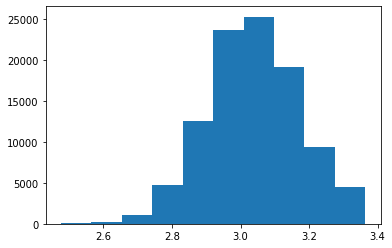

In [167]:
import scipy.stats as stats

lamb=stats.boxcox_normmax(airbnb_data.adjusted_price, brack=(-1.9, 1.9)) # don't use "lambda" as it's a Python reserved word
print("Lambda:", lamb)
y_t=(np.power(airbnb_data.adjusted_price,-0.2282)-1)/-0.2282

plt.hist(y_t);

In [224]:
airbnb_data["log_reviews"] = np.log10(airbnb_data.number_of_reviews)
airbnb_data["log_price"] = np.log10(airbnb_data.adjusted_price)

airbnb_data["years_since_2015"] = airbnb_data.year - 2015
airbnb_data["years_since_2015_squared"] = airbnb_data.years_since_2015 ** 2

airbnb_data["bedrooms_per_bathrooms"] = airbnb_data.bedrooms / airbnb_data.bathrooms
airbnb_data["log_beds_per_bedrooms"] = np.log10( airbnb_data.beds / airbnb_data.bedrooms )

airbnb_data["log_beds_per_bedrooms_squared"] = airbnb_data.log_beds_per_bedrooms ** 2
airbnb_data["accommodates_squared"] = airbnb_data.accommodates ** 2
airbnb_data["month_squared"] = airbnb_data.month ** 2

airbnb_data["adjusted_score"] = np.log10(1.025 - airbnb_data["review_scores_rating"] / 100)

airbnb_data["is_summer"] = False
airbnb_data["is_winter"] = False

airbnb_data.loc[airbnb_data.month.isin([1,2,11,12]), "is_winter"] = True
airbnb_data.loc[airbnb_data.month.isin([6,7,8,9]), "is_summer"] = True

airbnb_data["is_january"] = airbnb_data.month == 1
airbnb_data["is_february"] = airbnb_data.month == 2
airbnb_data["is_march"] = airbnb_data.month == 3
airbnb_data["is_april"] = airbnb_data.month == 4
airbnb_data["is_may"] = airbnb_data.month == 5
airbnb_data["is_june"] = airbnb_data.month == 6
# airbnb_data["is_july"] = airbnb_data.month == 7
airbnb_data["is_august"] = airbnb_data.month == 8
airbnb_data["is_september"] = airbnb_data.month == 9
airbnb_data["is_october"] = airbnb_data.month == 10
airbnb_data["is_november"] = airbnb_data.month == 11
airbnb_data["is_december"] = airbnb_data.month == 12


### Finalize initial dataset

In [225]:
airbnb_data.sort_index(axis=1, inplace=True)
airbnb_data.reset_index(drop=True, inplace=True)

reordered_columns = [
    "id", "neighbourhood_group", "neighbourhood", 
    "price", "number_of_reviews", "review_scores_rating", 
    "property_type", "month_count", "date", "year"
]

data_columns = airbnb_data.columns.tolist()
for reordered_column in reversed(reordered_columns):
    data_columns.insert(0, data_columns.pop(data_columns.index(reordered_column)))
    airbnb_data = airbnb_data.reindex(columns=data_columns)

backup_data_3 = airbnb_data.copy()


### Print database summaries

In [226]:
airbnb_data = backup_data_3.copy()


In [227]:
list(airbnb_data.columns)


['id',
 'neighbourhood_group',
 'neighbourhood',
 'price',
 'number_of_reviews',
 'review_scores_rating',
 'property_type',
 'month_count',
 'date',
 'year',
 'accommodates',
 'accommodates_squared',
 'adjusted_price',
 'adjusted_score',
 'bathrooms',
 'bedrooms',
 'bedrooms_per_bathrooms',
 'beds',
 'is_april',
 'is_august',
 'is_december',
 'is_february',
 'is_january',
 'is_june',
 'is_march',
 'is_may',
 'is_november',
 'is_october',
 'is_september',
 'is_summer',
 'is_winter',
 'latitude',
 'log_beds_per_bedrooms',
 'log_beds_per_bedrooms_squared',
 'log_price',
 'log_reviews',
 'longitude',
 'month',
 'month_squared',
 'years_since_2015',
 'years_since_2015_squared']

In [228]:
unique_ids = sorted(airbnb_data.id.unique())
len(unique_ids)


8868

In [229]:
airbnb_data.describe()


,id,price,number_of_reviews,review_scores_rating,month_count,year,accommodates,accommodates_squared,adjusted_price,adjusted_score,bathrooms,bedrooms,bedrooms_per_bathrooms,beds,latitude,log_beds_per_bedrooms,log_beds_per_bedrooms_squared,log_price,log_reviews,longitude,month,month_squared,years_since_2015,years_since_2015_squared
count,1.007630e+05,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.00000,100763.000000,100763.000000
mean,1.233394e+07,202.864464,57.618521,93.414220,18.339639,2017.437055,4.186100,20.569812,200.711002,-1.111091,1.127324,1.562677,1.412689,2.157300,40.722938,0.123943,0.042139,2.258151,1.558284,-73.965600,6.397854,51.79031,2.437055,7.000695
std,9.201642e+06,98.241543,58.136317,5.346045,11.187353,1.030275,1.745396,16.737161,97.215325,0.248665,0.353392,0.719627,0.606070,1.120208,0.048465,0.163637,0.068967,0.193674,0.436292,0.026953,3.295129,44.44036,1.030275,5.104120
min,3.831000e+03,39.000000,4.000000,50.000000,3.000000,2016.000000,1.000000,1.000000,38.373391,-1.602060,1.000000,1.000000,0.500000,1.000000,40.572357,-0.477121,0.000000,1.584030,0.602060,-74.037711,1.000000,1.00000,1.000000,1.000000
25%,3.775259e+06,135.000000,17.000000,91.000000,9.000000,2017.000000,3.000000,9.000000,133.388149,-1.259637,1.000000,1.000000,1.000000,1.000000,40.685701,0.000000,0.000000,2.125117,1.230449,-73.988419,4.000000,16.00000,2.000000,4.000000
50%,1.163678e+07,180.000000,38.000000,95.000000,16.000000,2018.000000,4.000000,16.000000,177.144662,-1.124939,1.000000,1.000000,1.000000,2.000000,40.719293,0.000000,0.000000,2.248328,1.579784,-73.964869,6.000000,36.00000,3.000000,9.000000
75%,1.986157e+07,250.000000,78.000000,97.000000,26.000000,2018.000000,5.000000,25.000000,246.034253,-0.939302,1.000000,2.000000,2.000000,3.000000,40.755382,0.301030,0.090619,2.390996,1.892095,-73.946935,9.000000,81.00000,3.000000,9.000000
max,3.526248e+07,600.000000,467.000000,100.000000,41.000000,2019.000000,9.000000,81.000000,600.000000,-0.279841,4.000000,5.000000,5.000000,8.000000,40.876339,0.903090,0.815572,2.778151,2.669317,-73.856760,12.000000,144.00000,4.000000,16.000000


In [230]:
airbnb_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100763 entries, 0 to 100762
Data columns (total 41 columns):
id                               100763 non-null int64
neighbourhood_group              100763 non-null object
neighbourhood                    100763 non-null object
price                            100763 non-null float64
number_of_reviews                100763 non-null int64
review_scores_rating             100763 non-null float64
property_type                    100763 non-null object
month_count                      100763 non-null float64
date                             100763 non-null object
year                             100763 non-null int64
accommodates                     100763 non-null int64
accommodates_squared             100763 non-null int64
adjusted_price                   100763 non-null float64
adjusted_score                   100763 non-null float64
bathrooms                        100763 non-null float64
bedrooms                         100763 non-null

### Plot useful information

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


Text(0, 0.5, 'latitude')

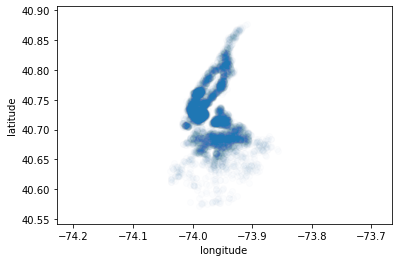

In [231]:
%matplotlib inline

cur_latitudes = [cur_item[0] for cur_item in airbnb_data.groupby("id").latitude.unique()]
cur_longitudes = [cur_item[0] for cur_item in airbnb_data.groupby("id").longitude.unique()]

plt.scatter(cur_longitudes, cur_latitudes,alpha=0.01);
plt.axes().set_aspect('equal', 'datalim')

plt.xlabel("longitude")
plt.ylabel("latitude")


In [232]:
def rental_plot(id_index, borough):
    cur_id = airbnb_data[airbnb_data.neighbourhood_group == borough].id.unique()[id_index]
    
    rental_rows = airbnb_data[
        (airbnb_data.id == cur_id) & 
        (airbnb_data.neighbourhood_group == borough)
    ]
    
    cur_x = [ 
        datetime.datetime(year=year, month=month, day=1) 
        for (year, month) in zip(rental_rows.year, rental_rows.month) 
    ]
    
    cur_y = rental_rows.price
    
    plt.plot(cur_x, cur_y)
    plt.scatter(cur_x, cur_y)
    
    plt.ylim(0,1.1*cur_y.max())
    

In [233]:
%matplotlib inline

interact(
    rental_plot, 
    borough=fixed("Manhattan"), 
    id_index=widgets.IntSlider(
        min=0, step=1, value=0, 
        max=len(airbnb_data[airbnb_data.neighbourhood_group == "Manhattan"].id.unique())-1
    )
);


interactive(children=(IntSlider(value=0, description='id_index', max=4978), Output()), _dom_classes=('widget-i…

In [234]:
%matplotlib inline

interact(
    rental_plot, 
    borough=fixed("Brooklyn"), 
    id_index=widgets.IntSlider(
        min=0, step=1, value=0, 
        max=len(airbnb_data[airbnb_data.neighbourhood_group == "Brooklyn"].id.unique())-1
    )
);


interactive(children=(IntSlider(value=0, description='id_index', max=3888), Output()), _dom_classes=('widget-i…

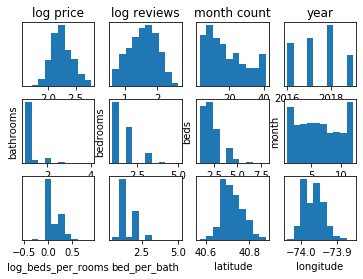

In [235]:
%matplotlib inline

plt.subplot(3,4,1)
plt.hist(airbnb_data.log_price);
plt.title("log price")
plt.yticks([], [])

plt.subplot(3,4,2)
plt.hist(airbnb_data.log_reviews);
plt.title("log reviews")
plt.yticks([], [])

plt.subplot(3,4,3)
plt.hist(airbnb_data.month_count);
plt.title("month count")
plt.yticks([], [])

plt.subplot(3,4,4)
plt.hist(airbnb_data.year);
plt.title("year")
plt.yticks([], [])

plt.subplot(3,4,5)
plt.hist(airbnb_data.bathrooms);
plt.ylabel("bathrooms")
plt.yticks([], [])

plt.subplot(3,4,6)
plt.hist(airbnb_data.bedrooms);
plt.ylabel("bedrooms")
plt.yticks([], [])

plt.subplot(3,4,7)
plt.hist(airbnb_data.beds);
plt.ylabel("beds")
plt.yticks([], [])

plt.subplot(3,4,8)
plt.hist(airbnb_data.month);
plt.ylabel("month")
plt.yticks([], [])

plt.subplot(3,4,9)
plt.hist(airbnb_data.log_beds_per_bedrooms);
plt.xlabel("log_beds_per_rooms")
plt.yticks([], [])

plt.subplot(3,4,10)
plt.hist(airbnb_data.bedrooms_per_bathrooms);
plt.xlabel("bed_per_bath")
plt.yticks([], [])

plt.subplot(3,4,11)
plt.hist(airbnb_data.latitude);
plt.xlabel("latitude")
plt.yticks([], [])

plt.subplot(3,4,12)
plt.hist(airbnb_data.longitude);
plt.xlabel("longitude")
plt.yticks([], []);


In [236]:
plot_dict = {}

for plot_year in sorted(airbnb_data.year.unique()):
    plot_months = []
    plot_prices = []
    plot_counts = []
    
    for plot_month in 1+np.arange(12):
        plot_data = airbnb_data[
            (airbnb_data.year == plot_year) & (airbnb_data.month == plot_month)
        ]
        
        if len(plot_data) == 0: continue
        plot_months.append(plot_data.month.iloc[0])
        plot_prices.append(plot_data.price.mean())
        plot_counts.append(len(plot_data))
        
    plot_dict[plot_year] = (plot_months, plot_prices, plot_counts)

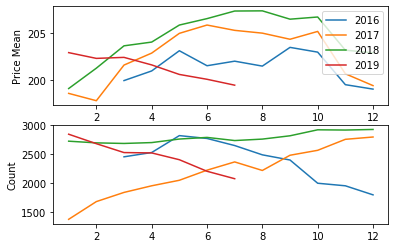

In [237]:
plot_y_max = 0

plt.subplot(2,1,1)
for cur_key, cur_value in plot_dict.items():
    plot_months, plot_prices, plot_counts = cur_value
    plt.plot(plot_months, plot_prices, label=cur_key);

plt.ylabel("Price Mean")
plt.legend();

plt.subplot(2,1,2)
for cur_key, cur_value in plot_dict.items():
    plot_months, plot_prices, plot_counts = cur_value
    plt.plot(plot_months, plot_counts, label=cur_key);

plt.ylabel("Count");
# plt.legend();

In [261]:
airbnb_data.to_pickle("./data/pickles/airbnb_data.pkl")


In [239]:
import seaborn as sns

In [240]:
pd.set_option('display.expand_frame_repr', False)
pd.options.display.width = 0
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
airbnb_data.describe()

,id,price,number_of_reviews,review_scores_rating,month_count,year,accommodates,accommodates_squared,adjusted_price,adjusted_score,bathrooms,bedrooms,bedrooms_per_bathrooms,beds,latitude,log_beds_per_bedrooms,log_beds_per_bedrooms_squared,log_price,log_reviews,longitude,month,month_squared,years_since_2015,years_since_2015_squared
count,1.007630e+05,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.00000,100763.000000,100763.000000
mean,1.233394e+07,202.864464,57.618521,93.414220,18.339639,2017.437055,4.186100,20.569812,200.711002,-1.111091,1.127324,1.562677,1.412689,2.157300,40.722938,0.123943,0.042139,2.258151,1.558284,-73.965600,6.397854,51.79031,2.437055,7.000695
std,9.201642e+06,98.241543,58.136317,5.346045,11.187353,1.030275,1.745396,16.737161,97.215325,0.248665,0.353392,0.719627,0.606070,1.120208,0.048465,0.163637,0.068967,0.193674,0.436292,0.026953,3.295129,44.44036,1.030275,5.104120
min,3.831000e+03,39.000000,4.000000,50.000000,3.000000,2016.000000,1.000000,1.000000,38.373391,-1.602060,1.000000,1.000000,0.500000,1.000000,40.572357,-0.477121,0.000000,1.584030,0.602060,-74.037711,1.000000,1.00000,1.000000,1.000000
25%,3.775259e+06,135.000000,17.000000,91.000000,9.000000,2017.000000,3.000000,9.000000,133.388149,-1.259637,1.000000,1.000000,1.000000,1.000000,40.685701,0.000000,0.000000,2.125117,1.230449,-73.988419,4.000000,16.00000,2.000000,4.000000
50%,1.163678e+07,180.000000,38.000000,95.000000,16.000000,2018.000000,4.000000,16.000000,177.144662,-1.124939,1.000000,1.000000,1.000000,2.000000,40.719293,0.000000,0.000000,2.248328,1.579784,-73.964869,6.000000,36.00000,3.000000,9.000000
75%,1.986157e+07,250.000000,78.000000,97.000000,26.000000,2018.000000,5.000000,25.000000,246.034253,-0.939302,1.000000,2.000000,2.000000,3.000000,40.755382,0.301030,0.090619,2.390996,1.892095,-73.946935,9.000000,81.00000,3.000000,9.000000
max,3.526248e+07,600.000000,467.000000,100.000000,41.000000,2019.000000,9.000000,81.000000,600.000000,-0.279841,4.000000,5.000000,5.000000,8.000000,40.876339,0.903090,0.815572,2.778151,2.669317,-73.856760,12.000000,144.00000,4.000000,16.000000


In [257]:
%matplotlib inline

def hist_plot(var):
    dd = airbnb_data[var]
    
    try:
        plt.hist(dd)
    except:
        plt.hist([ int(ddd) for ddd in dd ])

interact(
    hist_plot, 
    var=list(airbnb_data.columns)
);


interactive(children=(Dropdown(description='var', options=('id', 'neighbourhood_group', 'neighbourhood', 'pric…

In [258]:
%matplotlib inline

def hex_plot(xvar, yvar):
    x = [ float(xx) for xx in airbnb_data[xvar] ]
    y = [ float(yy) for yy in airbnb_data[yvar] ]

    with sns.axes_style("white"):
        sns.jointplot(x=x, y=y, kind="hex", color="k");
        
    plt.xlabel(xvar)
    plt.ylabel(yvar)

interact(
    hex_plot, 
    xvar=list(airbnb_data.describe().columns),
    yvar=reversed(list(airbnb_data.describe().columns))
);


interactive(children=(Dropdown(description='xvar', options=('id', 'price', 'number_of_reviews', 'review_scores…

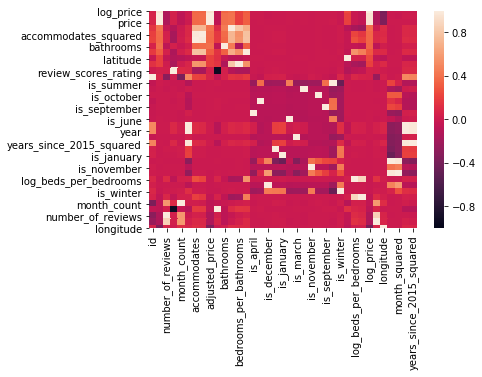

In [259]:
corr = airbnb_data.corr()
corr.sort_values("log_price", ascending=False, inplace=True)

sns.heatmap(corr, vmin=-1, vmax=+1)